# CNN Basics

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
!rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
import imitools as I

## Basic Example

In [12]:
image = torch.ones(8, 8)
image[:, 2:6] = 0
image

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [38]:
# This a kernal to detect horizontal edges.
kernal = torch.FloatTensor([[1, -1]])

In [69]:
def run_conv(X, K):
    kw, kh = K.shape
    xw, xh = X.shape
    yw = xw - (kw - 1)
    yh = xh - (kh - 1)
    
    Y = torch.zeros(yw, yh)
    for u in range(yw):
        for v in range(yh):
            selection = X[u:u+kw, v:v+kh]
            Y[u, v] = (selection*K).sum()
    return Y

In [46]:
# It detects horizontal edges.
## 1 for white -> black, -1 for black -> white
run_conv(image, torch.FloatTensor([[1, -1]]))

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [45]:
# It cannot detect vertical edges
run_conv(image.T, torch.FloatTensor([[1, -1]]))

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])

In [70]:
# It cannot detect vertical edges, if we chnage the kernal
run_conv(image.T, torch.FloatTensor([
    [1],
    [-1]
]))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## Training a Kernal

We can try to find a kernal by training a bit.

In [78]:
X = image
Y = run_conv(image, torch.FloatTensor([[1, -1]]))
X, Y

(tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.]]),
 tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]))

Here, we are trying for find the kernal to detect these edges via SGD.

initial K: tensor([[0.7470, 0.1434]], requires_grad=True)
tensor([[ 0.9615, -0.9615]], requires_grad=True)


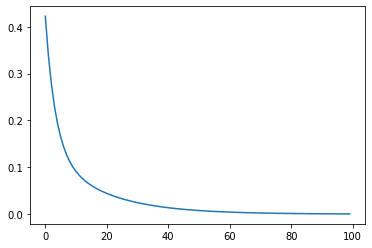

In [91]:
K = torch.rand(1, 2)
K.requires_grad_()
print("initial K:", K)

# the loop
losses = []
for i in range(100):
    if K.grad is not None:
        K.grad.zero_()
        
    yhat = run_conv(X, K)
    loss = ((Y - yhat)**2).mean()
    loss.backward()
    losses.append(loss.item())
    
    with torch.no_grad():
        K -= K.grad * 0.1
        
plt.plot(losses)
print(K)

In [93]:
with torch.no_grad():
    print(run_conv(image, K).round())

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])
